## Driving analysis

This notebook will showcase the data manipulation and analysis of a test drive from one of the Revolve NTNU drivers. Everything in here, except from the dataset, is independent of Revolve NTNU. The data is gathered from a 2022 test drive, and conists of the acceleration in longitudal direction (INS_ax) and velocity in longitudal and latitudal direction (INS_vx and INS_vy) as well as GPS coordinates (GNSS_longitude and GNSS_latitude). It is initially stored in "test_drive_220801.csv".

The purpose of this analysis is to gain insights about the driving that can help the drivers improve their skills. More specifically, the notebook will show:
* Aquisition of lap times and average velocity
* Acceleration graph comparison between laps aligned on distance driven
* Acceleration colored track-visualization

In [28]:
import matplotlib.pyplot as plt
%matplotlib widget
import mplcursors

import pandas as pd

### Getting the data

I want to put my data into a Pandas Dataframe. Pandas can easily load a csv-file into the table-like class, and the Dataframe has lots of built-in functionality that will be proven helpfull such as:
* The apply method that helps performing calculations on entire columns of data surprisingly fast.
* The loc-functionality that is helpfull when filtering and locating data.

In [29]:
# Load csv into pandas dataframe
df = pd.read_csv("test_drive_220801.csv", index_col=0)

# Convert lap column to int
df.lap = df.lap.astype(int)

print(df)

                time  lap  GNSS_latitude  GNSS_longitude    INS_ax     INS_vx
0           0.000000    1      63.464089       10.924229       NaN        NaN
1           0.002153    1            NaN             NaN -2.408677  15.450418
2           0.002166    1      63.464089       10.924229       NaN        NaN
3           0.004951    1            NaN             NaN -2.493580  15.443852
4           0.004964    1      63.464089       10.924230       NaN        NaN
...              ...  ...            ...             ...       ...        ...
1501935  2083.598071   67      63.464090       10.924228       NaN        NaN
1501936  2083.601102   67            NaN             NaN -1.615229  17.321484
1501937  2083.601115   67      63.464090       10.924229       NaN        NaN
1501938  2083.603136   67            NaN             NaN -1.451486  17.318304
1501939  2083.603150   67      63.464089       10.924230       NaN        NaN

[1501940 rows x 6 columns]


### Lap times and average velocity

Let us first get an overview of the lap times and the average velocity for each lap. Usually, the driver has some sense of which periods of the test drive went okay and when they were a bit behind. These simple statistics can confirm or contradict their believes, helping them in finding out were to look closer.

We don't need the gps-data right now, so let's branch out into a INS-dataframe and get rid of the NaN-values. In addition, we can align the time so that each lap starts at 0.

In [30]:
# Copy the df and get rid of GPS data
df_INS = df.drop(columns=["GNSS_longitude", "GNSS_latitude"]).dropna()

# Align the laps based on time so all laps start at 0 seconds
df_INS.time = df_INS.groupby("lap", group_keys=False).time.apply(lambda x: x - x.min())

print(df_INS)

              time  lap    INS_ax     INS_vx
1         0.000000    1 -2.408677  15.450418
3         0.002798    1 -2.493580  15.443852
5         0.004931    1 -2.699690  15.436881
7         0.007985    1 -2.844433  15.429581
9         0.009992    1 -2.928234  15.422129
...            ...  ...       ...        ...
1501930  29.194823   67 -1.657653  17.332680
1501932  29.197718   67 -1.565519  17.329159
1501934  29.199801   67 -1.584281  17.325146
1501936  29.202846   67 -1.615229  17.321484
1501938  29.204880   67 -1.451486  17.318304

[750970 rows x 4 columns]


Now we can get the lap times and average velocity, and make a dataframe with the statistics from each lap

In [31]:
lap_statistics = {
    "lap": None,
    "lap_time": None,
    "average_velocity": None
}

lap_statistics["lap"] = df_INS.lap.unique()
lap_statistics["lap_time"] = df_INS.groupby("lap").time.max()
lap_statistics["average_velocity"] = df_INS.groupby("lap").INS_vx.mean()

# Create new df with lap time and average velocity
df_lap_statistics = pd.DataFrame(lap_statistics)

print(df_lap_statistics)

     lap   lap_time  average_velocity
lap                                  
1      1  31.922681         10.476600
2      2  28.479854         11.726547
3      3  28.219763         11.550439
4      4  27.451424         12.042820
5      5  26.861127         12.645519
..   ...        ...               ...
63    63  27.899303         12.028062
64    64  28.046920         12.118171
65    65  27.441223         12.074087
66    66  27.923722         11.975306
67    67  29.204880         11.575525

[67 rows x 3 columns]


#### Early take-aways

Let's find the fastest lap. This can be used as a reference when evaluating the rest of the test drive. Hopefully, the fastest out of 67 laps will be quite a good drive, which means drivers can compare braking and acceleration in this lap to the braking and acceleration in the other laps to understand where it went wrong in the slower ones.

There are two ways of finding the fastest lap. It will have the highest average velocity and the shortest lap time. Preferably, they coincide.

In [32]:
# Get the fastest lap based on shortest lap time
fastest_lap_from_lap_time = df_lap_statistics.loc[
    df_lap_statistics.lap_time == df_lap_statistics.lap_time.min()
]

# Get the fastest lap based on highest avg velocity
fastest_lap_from_avg_velocity = df_lap_statistics.loc[
    df_lap_statistics.average_velocity == df_lap_statistics.average_velocity.max()
]

print(fastest_lap_from_lap_time)
print(fastest_lap_from_avg_velocity)

     lap  lap_time  average_velocity
lap                                 
32    32  25.30475         12.732586
     lap   lap_time  average_velocity
lap                                  
27    27  25.787555         12.775216


Unfortunately, the fastest laps do not coincide. This can have several explanations, some of which are:
* The driving path could have different length even when driving on the same track.
* Latitudal velocity is a factor in lap time as well
* Inaccurate measuring in both timing and acceleration

However, both lap 32 and lap 27 can be used as templates for quite fast drives.

### Visual lap comparison

Let us move on to a more visual representation of the laps. I want to compare the laps' acceleration to each other so as to analyse where the driver is braking too early or too late, or when they're braking too hard or too soft.

An aligned line graph comparison will do. It is not optimal aligning on time, but due to holes in the data, integrating to get distance is too inaccurate. Interpolation could help with this, but for now I will stick to aligning on time.

Let us try comparing lap 5 to the fast lap 32.

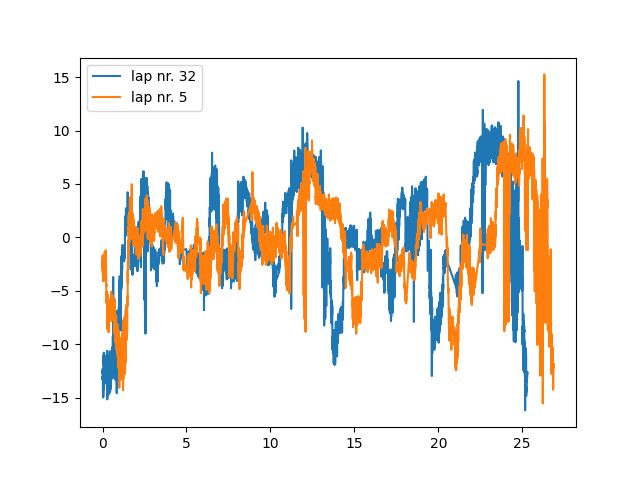

In [33]:
# Define which laps to compare
first_lap = 32
second_lap = 5

fig, ax = plt.subplots()

# Plot the first lap for comparison
ax.plot(df_INS.loc[df_INS.lap == first_lap, "time"], 
        df_INS.loc[df_INS.lap == first_lap, "INS_ax"], 
        label="lap nr. "+str(first_lap))

# Plot the second lap for comparison
ax.plot(df_INS.loc[df_INS.lap == second_lap, "time"], 
        df_INS.loc[df_INS.lap == second_lap, "INS_ax"], 
        label="lap nr. "+str(second_lap))

ax.legend()

From here, drivers can analyse what acceleration and braking pattern works for this track. The compared laps can be switched out easily by tweeking the variables.

### Showing the acceleration on track

Since we could not align the line graphs on distance, let us try visualizing the acceleration on a track map instead. Now we must get the GPS data from the original dataframe. However, let us interpolate the ax-values to get rid of the NaN-values.

In [34]:
# Copy df and get rid of tie and INS_vx columns
df_track = df.drop(columns=["time", "INS_vx"])

# Interpolate INS_ax and drop NaN values
df_track.INS_ax = df_track.INS_ax.interpolate()
df_track = df_track.dropna()

print(df_track)

         lap  GNSS_latitude  GNSS_longitude    INS_ax
2          1      63.464089       10.924229 -2.451128
4          1      63.464089       10.924230 -2.596635
6          1      63.464088       10.924231 -2.772061
8          1      63.464088       10.924231 -2.886333
10         1      63.464088       10.924232 -2.716826
...      ...            ...             ...       ...
1501931   67      63.464091       10.924227 -1.611586
1501933   67      63.464090       10.924228 -1.574900
1501935   67      63.464090       10.924228 -1.599755
1501937   67      63.464090       10.924229 -1.533358
1501939   67      63.464089       10.924230 -1.451486

[750969 rows x 4 columns]


Now we can plot a scatter map showing the track colored by acceleration for the lap. We can use the mosaic functionality in Matplotlib to compare laps. Mplcursors let us see exactly what the ax-values is on every part of the track by clicking the datapoints.

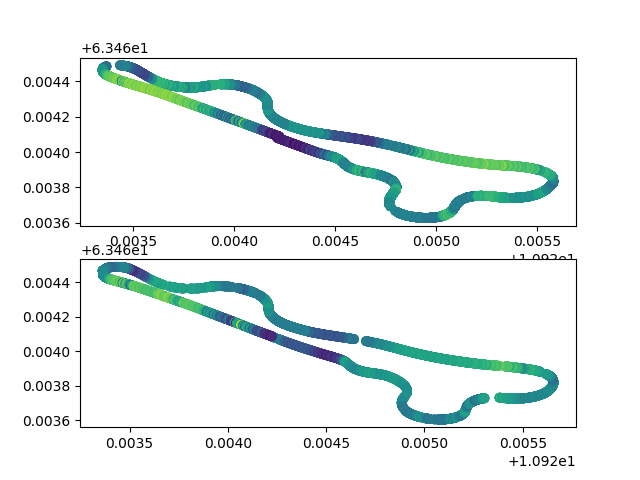

In [35]:
# Define which laps to compare
first_lap = 32
second_lap = 5

fig, (ax1, ax2) = plt.subplots(2)

# Plot first lap for comparison
ax1.scatter(df_track.loc[df_track.lap == first_lap, "GNSS_longitude"], 
            df_track.loc[df_track.lap == first_lap, "GNSS_latitude"], 
            c=df_track.loc[df_track.lap == first_lap, "INS_ax"])

# Plot second lap for comparison
ax2.scatter(df_track.loc[df_track.lap == second_lap, "GNSS_longitude"], 
            df_track.loc[df_track.lap == second_lap, "GNSS_latitude"],
            c=df_track.loc[df_track.lap == second_lap, "INS_ax"])

mplcursors.cursor()

### Summary

We have been analysing some of the data gathered from a test drive, and seen how we can use the data to produce statistics and visualization tools that can help drivers in improving their skills. 

We generated simple statistics about each lap to let the drivers get an overview of the drive and compare it to their own beliefs about the performance. This also lead to the realization that some of the data could have inaccuracies. We saw that using two different methods of getting the fastest lap, we ended up with two different results.

When creating the line graph comparison, we had to align the laps on time, which is not optimal for our use case. The graphs will naturally be unsynchronized due to the faster lap time on one of the laps. Preferably, we would align on distance driven, but this was difficult due to "holes" in some of the data. This could be somewhat fixed by interpolation, but that is a project for the future.

Instead of trying to align the line graphs perfectly, we also tried another visualization method. GPS data plotted in a scattered map, colored by acceleration, lets drivers see exactly where on the track braking and acceleration should be applied.

The analysis here could be expanded upon significantly. The graph alignment is one aspect. Something else is generating more detailed statistics, like how often a driver brakes too early or too late using the fastest laps as "solutions". However, this is what I had time for in this round. Hopefully some of it is deemed useful.